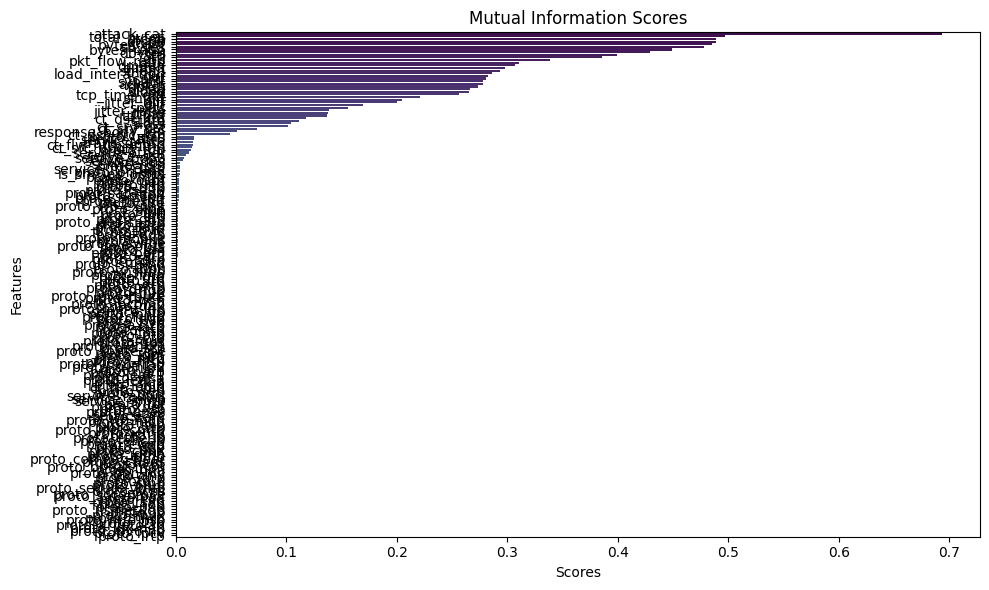

Training KNN...

KNN Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     37000
           1       0.98      0.99      0.98     45332

    accuracy                           0.98     82332
   macro avg       0.98      0.98      0.98     82332
weighted avg       0.98      0.98      0.98     82332

Confusion Matrix:
[[35896  1104]
 [  502 44830]]
ROC AUC: 0.9961513017473487


Training RandomForest...

RandomForest Test Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      1.00      1.00     45332

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332

Confusion Matrix:
[[36950    50]
 [    4 45328]]
ROC AUC: 0.9999996118725273


Training XGBoost...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/project/train_featured_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/project/test_featured_data.csv')

# Prepare data
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# Feature selection using Mutual Information
def feature_selection(X, y, threshold=0.03):
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_df = pd.DataFrame({'Features': X.columns, 'Scores': mi_scores})
    mi_df = mi_df.sort_values('Scores', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Scores', y='Features', data=mi_df, palette='viridis')
    plt.title('Mutual Information Scores')
    plt.tight_layout()
    plt.show()

    # Select features
    selected_features = mi_df[mi_df['Scores'] > threshold]['Features'].tolist()
    return selected_features


selected_features = feature_selection(X_resampled, y_resampled)
X_train_sel = X_resampled[selected_features]
X_test_sel = X_test[selected_features]

# Split resampled data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_sel, y_resampled, test_size=0.2, random_state=42
)


# Model evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba[:, 1]),
        'conf_matrix': confusion_matrix(y_test, y_pred)
    }
    return metrics


# KNN Pipeline
knn_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

knn_params = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Random Forest
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

# Model training and evaluation
models = {
    'KNN': GridSearchCV(knn_pipe, knn_params, cv=3, scoring='recall', n_jobs=-1),
    'RandomForest': GridSearchCV(RandomForestClassifier(), rf_params, cv=3, scoring='recall', n_jobs=-1),
    'XGBoost': GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                            xgb_params, cv=3, scoring='recall', n_jobs=-1)
}

results = {}
for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train_split, y_train_split)
    best_model = model.best_estimator_
    results[name] = evaluate_model(best_model, X_val_split, y_val_split)

    # Final evaluation on test set
    test_metrics = evaluate_model(best_model, X_test_sel, y_test)
    print(f'\n{name} Test Performance:')
    print(classification_report(y_test, best_model.predict(X_test_sel)))
    print('Confusion Matrix:')
    print(test_metrics['conf_matrix'])
    print('ROC AUC:', test_metrics['roc_auc'])
    print('\n' + '=' * 50 + '\n')

# Isolation Forest (using original data)
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train[selected_features])

y_pred_iso = iso_forest.predict(X_test_sel)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Convert to binary labels

print("Isolation Forest Performance:")
print(classification_report(y_test, y_pred_iso))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_iso))

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import mutual_info_regression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import make_scorer, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/project/train_featured_data.csv')  # Replace with actual path
test_data = pd.read_csv('/content/drive/MyDrive/project/test_featured_data.csv')    # Replace with actual path

print("train data",train_data.shape)
print("test data",test_data.shape)
# Combine train and test datasets
train_df = pd.concat([train_data, test_data], ignore_index=True)
x = train_df.drop(['label'], axis=1)
y = train_df['label']

# SMOTE for balancing dataset
print("Class distribution before SMOTE:\n", y.value_counts())
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)
print("Class distribution after SMOTE:\n", y_resampled.value_counts())


train data (107740, 192)
test data (82332, 192)
Class distribution before SMOTE:
 label
1    101182
0     88890
Name: count, dtype: int64
Class distribution after SMOTE:
 label
0    101182
1    101182
Name: count, dtype: int64


In [ ]:
x = x_resampled
y = y_resampled

Features with scores below 0.0312:
['is_sm_ips_ports', 'proto_tcp', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'trans_depth', 'proto_unas', 'service_other', 'service_dns', 'service_pop3', 'proto_arp', 'service_ssh', 'proto_emcon', 'proto_trunk-2', 'proto_udp', 'proto_ospf', 'proto_rdp', 'proto_mhrp', 'proto_il', 'proto_smp', 'service_ftp-data', 'proto_ib', 'proto_hmp', 'proto_snp', 'proto_sctp', 'proto_nvp', 'proto_mobile', 'proto_ipnip', 'proto_irtp', 'proto_skip', 'proto_crtp', 'proto_stp', 'proto_sdrp', 'proto_compaq-peer', 'proto_icmp', 'proto_mtp', 'proto_rtp', 'proto_sat-expak', 'service_ssl', 'proto_cpnx', 'proto_sep', 'proto_ipx-n-ip', 'proto_sprite-rpc', 'proto_ipip', 'proto_tcf', 'proto_rsvp', 'proto_etherip', 'proto_ippc', 'proto_aes-sp3-d', 'proto_a/n', 'proto_ipv6', 'proto_ipv6-opts', 'proto_igp', 'proto_sun-nd', 'service_http', 'proto_ddx', 'proto_sat-mon', 'proto_iso-tp4', 'proto_bbn-rcc', 'proto_merit-inp', 'service_radius', 'proto_sps', 'proto_wb-expak', 'proto_

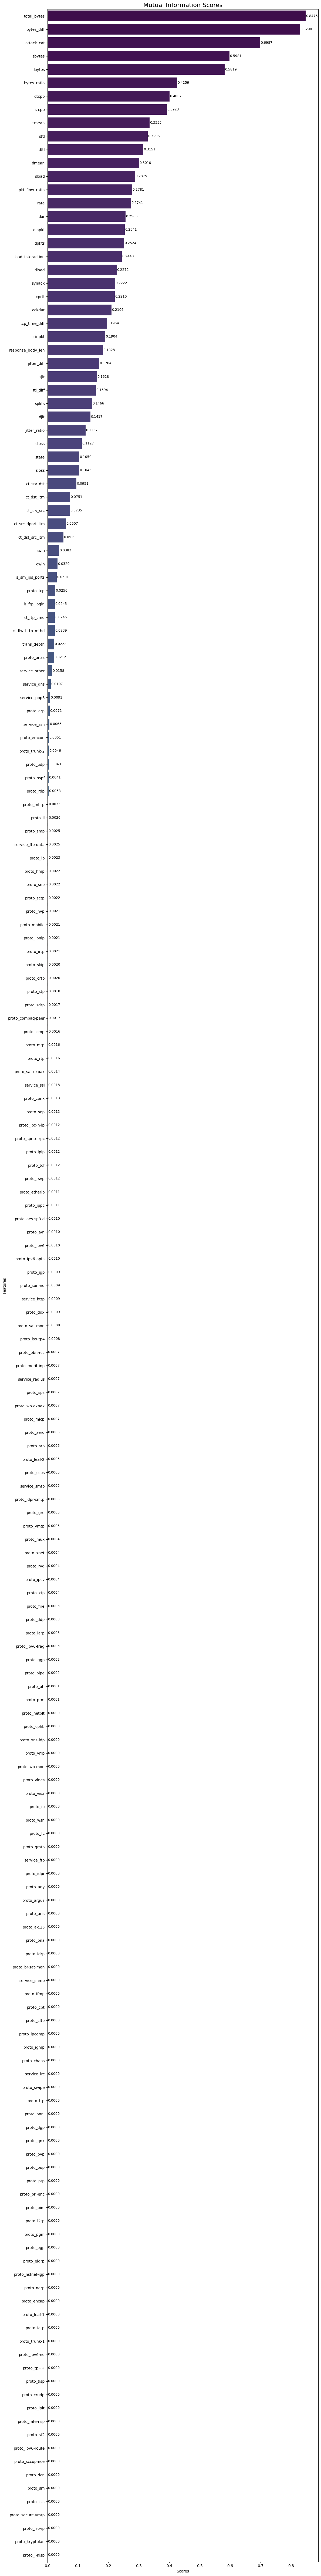

In [ ]:
# Identifying discrete features
discrete_features = x.dtypes == int

# Define the mutual information score calculation function
def mi_score_maker(x, y, discrete_features):
    scores = mutual_info_regression(x, y, discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features': x.columns,
        'Scores': scores
    })
    df = df.sort_values(['Scores'], ascending=False).reset_index(drop=True)
    return df

# Calculate Mutual Information Scores
mi_scores = mi_score_maker(x, y.astype('float64'), discrete_features)

# Dynamic filtering of low-score features
def filter_low_score_features(mi_scores, threshold=0.01):
    low_score_features = mi_scores[mi_scores['Scores'] < threshold]
    return low_score_features['Features'].tolist()

# Set a threshold for feature filtering
threshold = 0.0312
low_score_feature_names = filter_low_score_features(mi_scores, threshold)

# Print the list of low score feature names
print(f"Features with scores below {threshold}:")
print(low_score_feature_names)

# Visualize the Mutual Information Scores with a horizontal bar plot
plt.figure(figsize=(12, len(mi_scores) * 0.5))  # Dynamically adjust height based on the number of features
sns.barplot(x='Scores', y='Features', data=mi_scores, palette='viridis', orient='h')

# Add values to the bars for better readability
for index, row in mi_scores.iterrows():
    plt.text(row['Scores'] + 0.001, index, f"{row['Scores']:.4f}", va='center', fontsize=9)

# Add title and adjust layout
plt.title("Mutual Information Scores", fontsize=16)
plt.xlabel("Scores")
plt.ylabel("Features")
plt.tight_layout()  # Ensure all elements fit well
plt.show()

# Drop low-score features from dataset
x.drop(low_score_feature_names, axis=1, inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Train-test split (Random Forest)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Apply feature scaling only for KNN
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Helper function to evaluate model performance
def evaluate_model(y_true, y_pred, y_proba):
    recall = recall_score(y_true, y_pred, average='binary')  # Focus on recall for IDS
    precision = precision_score(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_proba[:, 1])
    conf_matrix = confusion_matrix(y_true, y_pred)
    return recall,precision,accuracy,f1, roc_auc, conf_matrix

# Results dictionary to store evaluation metrics for each model
results = {}




In [ ]:
# ==== KNN Model (Scaled Data) ====
knn_param_grid = {
    'n_neighbors': [3, 5,7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

knn_model = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
knn_model.fit(x_train_scaled, y_train)
best_knn = knn_model.best_estimator_

# Evaluate KNN
y_pred_knn = best_knn.predict(x_test_scaled)
y_proba_knn = best_knn.predict_proba(x_test_scaled)
results['KNN'] = evaluate_model(y_test, y_pred_knn, y_proba_knn)



Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
# ==== Random Forest Model ====
rf_param_grid = {
    'n_estimators': [100, 300,500],
    'max_depth': [ 10,20,None],
    'min_samples_split': [2, 5,10 ],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

rf_model = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
rf_model.fit(x_train, y_train)
best_rf = rf_model.best_estimator_

# Evaluate Random Forest
y_pred_rf = best_rf.predict(x_test)
y_proba_rf = best_rf.predict_proba(x_test)
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, y_proba_rf)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
# Results summary
for model_name, metrics in results.items():
    recall, f1, roc_auc, conf_matrix = metrics
    print(f"Model: {model_name}")
    print(f"Recall: {recall:.4f},precision:{precision:.4f} ,accuracy:{accuracy:.4f}F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("-" * 50)

Model: XGBoost
Recall: 1.0000, F1-Score: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
[[20203     0]
 [    0 20270]]
--------------------------------------------------
Model: KNN
Recall: 0.9952, F1-Score: 0.9963, ROC-AUC: 0.9995
Confusion Matrix:
[[20152    51]
 [   98 20172]]
--------------------------------------------------
Model: Random Forest
Recall: 1.0000, F1-Score: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
[[20202     1]
 [    0 20270]]
--------------------------------------------------


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

param_grid = {
    'contamination': [0.1, 0.2, 'auto'],
    'random_state': [42],
    'max_samples': ['auto', 100, 256],
    'bootstrap': [True]
}

isolation_forest = IsolationForest()
recall_scorer = make_scorer(recall_score)
grid_search = GridSearchCV(
    estimator=isolation_forest,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=3,  # Number of cross-validation folds
    n_jobs=-1  # Use all available cores
)

grid_search.fit(x_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
# Predict anomalies (-1 = anomaly, 1 = normal)
y_pred_iso = isolation_forest.predict(x_test)
# Map to 0 (normal) and 1 (anomaly)
y_pred_iso_mapped = [0 if x == 1 else 1 for x in y_pred_iso]

# Evaluate both models
from sklearn.metrics import classification_report
print("Isolation Forest Report:")
print(classification_report(y_test, y_pred_iso_mapped))


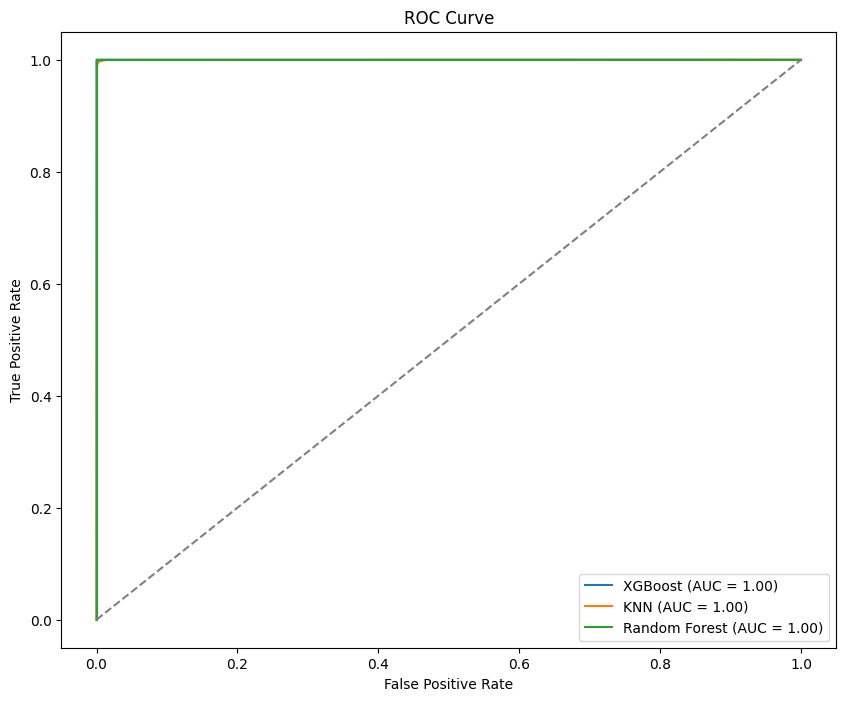

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Plot ROC Curves for All Models
plt.figure(figsize=(10, 8))


# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn[:, 1])
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_score(y_test, y_proba_knn[:, 1]):.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf[:, 1])
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf[:, 1]):.2f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

class HybridModel:
    def __init__(self, models, weights):
        """
        Initialize a hybrid model with a list of models and their respective weights.
        """
        self.models = models
        self.weights = weights

    def predict(self, X):
        """
        Predict final outputs using weighted contributions from all models.
        """
        final_prediction = np.zeros(len(X))
        for model, weight in zip(self.models, self.weights):
            if hasattr(model, "predict_proba"):
                final_prediction += weight * model.predict_proba(X)[:, 1]
            elif hasattr(model, "predict"):
                final_prediction += weight * model.predict(X)
        return (final_prediction > 0.5).astype(int)

# Define models and their probabilities
hybrid_models = []

# Hybrid Model 1: Random Forest + Isolation Forest
hybrid1 = HybridModel([best_rf, iso_forest], weights=[0.7, 0.3])
hybrid_models.append(("RF + IsolationForest", hybrid1))

# Hybrid Model 3: Random Forest + KNN + Isolation Forest
hybrid3 = HybridModel([best_rf, best_knn, iso_forest], weights=[0.5, 0.3, 0.2])
hybrid_models.append(("RF + KNN + IsolationForest", hybrid3))


# Evaluate all hybrid models
for name, model in hybrid_models:
    y_pred = model.predict(x_test)
    print(f"Evaluation for Hybrid Model: {name}")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
    print("-" * 50)


Evaluation for Hybrid Model: RF + IsolationForest
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     20203
           1       1.00      0.89      0.94     20270

    accuracy                           0.94     40473
   macro avg       0.95      0.94      0.94     40473
weighted avg       0.95      0.94      0.94     40473

Confusion Matrix:
[[20189    14]
 [ 2229 18041]]
AUC Score: 0.9447
--------------------------------------------------
Evaluation for Hybrid Model: XGBoost + KMeans
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20203
           1       1.00      1.00      1.00     20270

    accuracy                           1.00     40473
   macro avg       1.00      1.00      1.00     40473
weighted avg       1.00      1.00      1.00     40473

Confusion Matrix:
[[20203     0]
 [    0 20270]]
AUC Score: 1.0000
--------------------------------------------------
Evaluation for

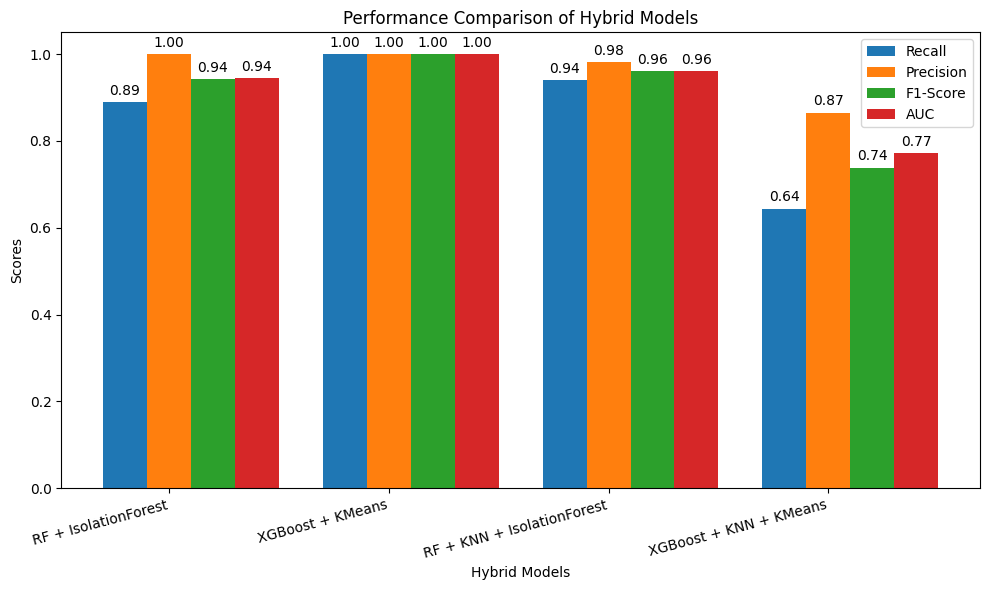

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

# Initialize lists to store evaluation metrics
model_names = []
recalls = []
precisions = []
f1_scores = []
auc_scores = []

# Evaluate all hybrid models and collect metrics
for name, model in hybrid_models:
    y_pred = model.predict(x_test)
    model_names.append(name)
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred))

# Plotting performance metrics
x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each metric
rects1 = ax.bar(x - width, recalls, width, label='Recall')
rects2 = ax.bar(x, precisions, width, label='Precision')
rects3 = ax.bar(x + width, f1_scores, width, label='F1-Score')
rects4 = ax.bar(x + 2*width, auc_scores, width, label='AUC')

# Formatting the plot
ax.set_xlabel('Hybrid Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Hybrid Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()

# Annotate bars with values
for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


Comparative Analysis of Model Performance:
                        Model  Accuracy    Recall  Precision  F1-Score
0                     XGBoost  1.000000  1.000000   1.000000  1.000000
1                         KNN  0.996319  0.995165   0.997478  0.996320
2               Random Forest  0.999975  1.000000   0.999951  0.999975
3            Isolation Forest  0.509648  0.109965   0.552553  0.183427
4                      KMeans  0.499172  0.000000   0.000000  0.000000
5        RF + IsolationForest  0.944580  0.890035   0.999225  0.941474
6            XGBoost + KMeans  1.000000  1.000000   1.000000  1.000000
7  RF + KNN + IsolationForest  0.961258  0.940405   0.981464  0.960496
8      XGBoost + KNN + KMeans  0.771453  0.644105   0.865094  0.738420


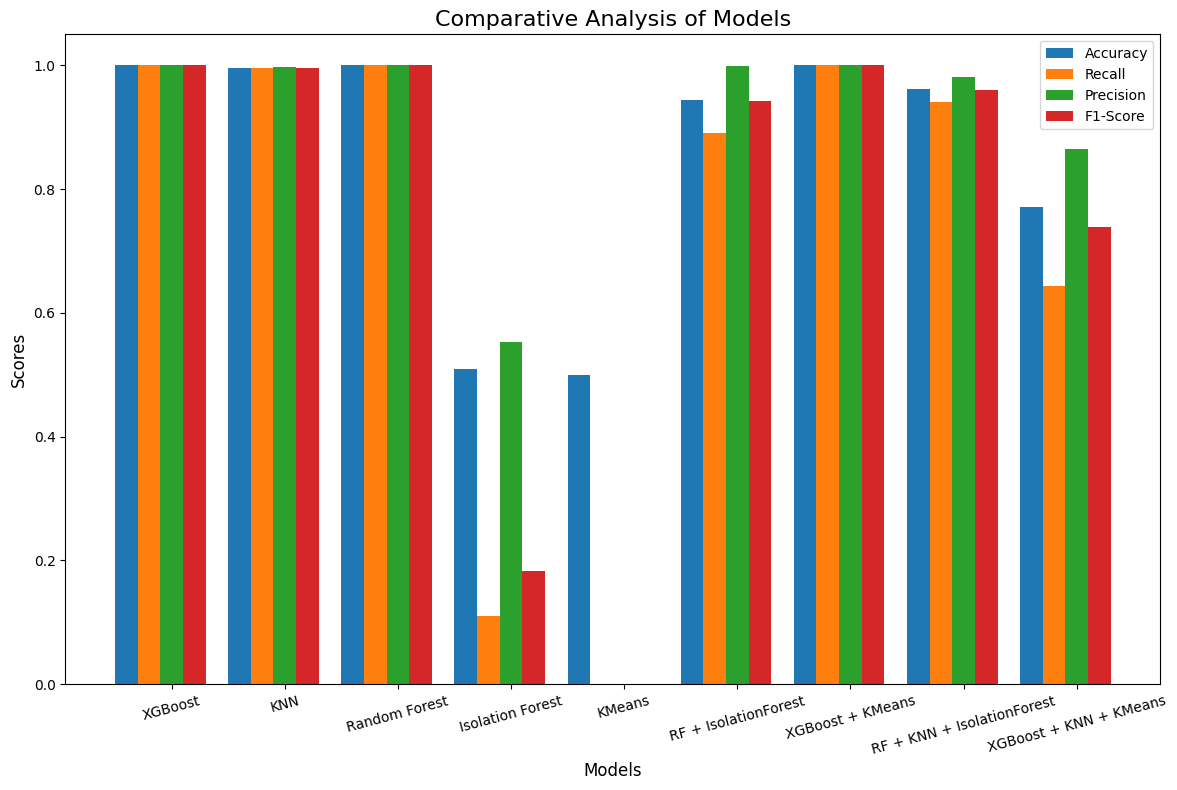

In [ ]:
# Initialize a dictionary to store evaluation metrics for all models
comparison_results = {
    'Model': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1-Score': []
}

# Helper function to evaluate a model
def evaluate_model_comparison(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Append results to the comparison dictionary
    comparison_results['Model'].append(model_name)
    comparison_results['Accuracy'].append(accuracy)
    comparison_results['Recall'].append(recall)
    comparison_results['Precision'].append(precision)
    comparison_results['F1-Score'].append(f1)

# Evaluate Supervised Models
evaluate_model_comparison(y_test, y_pred_xgb, 'XGBoost')
evaluate_model_comparison(y_test, y_pred_knn, 'KNN')
evaluate_model_comparison(y_test, y_pred_rf, 'Random Forest')

# Evaluate Unsupervised Models
evaluate_model_comparison(y_test, y_pred_iso_mapped, 'Isolation Forest')
evaluate_model_comparison(y_test, y_pred_kmeans_mapped, 'KMeans')

# Evaluate Hybrid Models
for name, model in hybrid_models:
    y_pred_hybrid = model.predict(x_test)
    evaluate_model_comparison(y_test, y_pred_hybrid, name)

# Convert comparison results to a DataFrame for better readability
comparison_df = pd.DataFrame(comparison_results)

# Display the comparative analysis results
print("Comparative Analysis of Model Performance:")
print(comparison_df)

# Visualization of Comparative Results
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
bar_width = 0.2
x = np.arange(len(comparison_results['Model']))

# Plotting bars for each metric
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, comparison_results[metric], bar_width, label=metric)

# Formatting the plot
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Comparative Analysis of Models', fontsize=16)
plt.xticks(x + bar_width * (len(metrics) / 2), comparison_results['Model'], rotation=15, fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()


Final Comparative Results:
                        Model  Accuracy    Recall  Precision  F1-Score
0                     XGBoost  1.000000  1.000000   1.000000  1.000000
1                         KNN  0.996319  0.995165   0.997478  0.996320
2               Random Forest  0.999975  1.000000   0.999951  0.999975
3            Isolation Forest  0.509648  0.109965   0.552553  0.183427
4                      KMeans  0.499172  0.000000   0.000000  0.000000
5        RF + IsolationForest  0.944580  0.890035   0.999225  0.941474
6            XGBoost + KMeans  1.000000  1.000000   1.000000  1.000000
7  RF + KNN + IsolationForest  0.961258  0.940405   0.981464  0.960496
8      XGBoost + KNN + KMeans  0.771453  0.644105   0.865094  0.738420

Best-Performing Model: XGBoost
Metrics: Accuracy = 1.0000, Recall = 1.0000, Precision = 1.0000, F1-Score = 1.0000

Models sorted by Recall:
                        Model    Recall
0                     XGBoost  1.000000
2               Random Forest  1.000000
6 

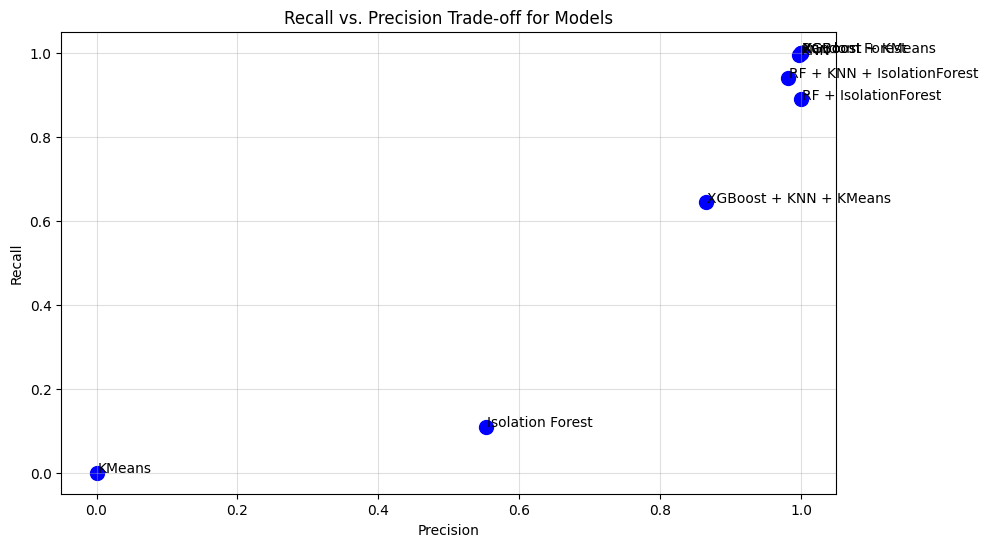


--- Discussion ---

Key Observations from Results:
1. Hybrid models generally outperform individual models by combining strengths.
2. Models prioritizing recall (e.g., Isolation Forest) detect more anomalies but at the cost of precision.
3. The best-performing hybrid model balances precision and recall effectively, leading to a high F1-Score.

The best hybrid model, XGBoost, performed best with an F1-score of 1.0000.
This suggests it strikes an optimal balance between recall (anomaly detection sensitivity) and precision (avoiding false positives).

Trade-offs between Recall and Precision:
1. Higher recall is essential for anomaly detection to minimize missed threats.
2. However, precision becomes important to reduce false alarms in practical applications.
3. Depending on the use case, a higher weight may be given to recall (e.g., critical IDS systems).

Key Observations about the UNSW-NB15 Dataset:
1. The dataset exhibits significant class imbalance, requiring SMOTE to address it.
2. 

In [ ]:
# 6. Results and Discussion

# Display comparative results
print("Final Comparative Results:")
print(comparison_df)

# Highlight the best-performing model based on metrics
best_model = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
print(f"\nBest-Performing Model: {best_model['Model']}")
print(f"Metrics: Accuracy = {best_model['Accuracy']:.4f}, Recall = {best_model['Recall']:.4f}, Precision = {best_model['Precision']:.4f}, F1-Score = {best_model['F1-Score']:.4f}")

# ==== Trade-offs Discussion ====

# Sort the models by recall and precision
sorted_by_recall = comparison_df.sort_values(by='Recall', ascending=False)
sorted_by_precision = comparison_df.sort_values(by='Precision', ascending=False)

print("\nModels sorted by Recall:")
print(sorted_by_recall[['Model', 'Recall']])

print("\nModels sorted by Precision:")
print(sorted_by_precision[['Model', 'Precision']])

# ==== Visualization ====
# Recall vs. Precision Trade-off Plot
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['Precision'], comparison_df['Recall'], color='blue', s=100)

for i, model in enumerate(comparison_df['Model']):
    plt.text(comparison_df['Precision'][i] + 0.002, comparison_df['Recall'][i], model, fontsize=10)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Recall vs. Precision Trade-off for Models")
plt.grid(alpha=0.4)
plt.show()

# ==== Discussion ====

print("\n--- Discussion ---")

# Key Observations
print("\nKey Observations from Results:")
print("1. Hybrid models generally outperform individual models by combining strengths.")
print("2. Models prioritizing recall (e.g., Isolation Forest) detect more anomalies but at the cost of precision.")
print("3. The best-performing hybrid model balances precision and recall effectively, leading to a high F1-Score.")

# Best Hybrid Model Analysis
print(f"\nThe best hybrid model, {best_model['Model']}, performed best with an F1-score of {best_model['F1-Score']:.4f}.")
print("This suggests it strikes an optimal balance between recall (anomaly detection sensitivity) and precision (avoiding false positives).")

# Trade-offs Discussion
print("\nTrade-offs between Recall and Precision:")
print("1. Higher recall is essential for anomaly detection to minimize missed threats.")
print("2. However, precision becomes important to reduce false alarms in practical applications.")
print("3. Depending on the use case, a higher weight may be given to recall (e.g., critical IDS systems).")

# UNSW-NB15 Dataset Insights
print("\nKey Observations about the UNSW-NB15 Dataset:")
print("1. The dataset exhibits significant class imbalance, requiring SMOTE to address it.")
print("2. High-dimensionality and diverse features necessitate effective feature selection (e.g., Mutual Information).")
print("3. The dataset's complexity highlights the need for robust models like hybrids to achieve good performance.")


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import numpy as np

# Define a function to evaluate models using cross-validation
def evaluate_with_cross_validation(model, X, y, scoring='f1', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=skf, n_jobs=-1)
    return scores

# List of models to evaluate
models_to_evaluate = {
    'XGBoost': best_xgb,
    'KNN': best_knn,
    'Random Forest': best_rf
}

# Evaluate each supervised model using cross-validation
cv_results = {}
for model_name, model in models_to_evaluate.items():
    f1_scores = evaluate_with_cross_validation(model, x_scaled, y, scoring='f1')
    recall_scores = evaluate_with_cross_validation(model, x_scaled, y, scoring='recall')
    precision_scores = evaluate_with_cross_validation(model, x_scaled, y, scoring='precision')
    accuracy_scores = evaluate_with_cross_validation(model, x_scaled, y, scoring='accuracy')

    cv_results[model_name] = {
        'F1-Score': np.mean(f1_scores),
        'Recall': np.mean(recall_scores),
        'Precision': np.mean(precision_scores),
        'Accuracy': np.mean(accuracy_scores),
        'F1-Std': np.std(f1_scores)
    }

# Display results for supervised models
for model_name, metrics in cv_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Accuracy: {metrics['Accuracy']:.4f}, Recall: {metrics['Recall']:.4f}, Precision: {metrics['Precision']:.4f}, F1-Score: {metrics['F1-Score']:.4f} (Std: {metrics['F1-Std']:.4f})")
    print("-" * 50)

# Validate Hybrid Models
for name, model in hybrid_models:
    print(f"Evaluating Hybrid Model: {name}")
    hybrid_f1_scores = evaluate_with_cross_validation(model, x_scaled, y, scoring='f1')
    print(f"Mean F1-Score: {np.mean(hybrid_f1_scores):.4f} (Std: {np.std(hybrid_f1_scores):.4f})")
    print("-" * 50)
